# Fig05_ColdPools
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 23.12.2019
    Date last modified: 23.12.2019

    ##############################################################
    Purpos:

    1) Calculate spatial properties and plot spatial properties of one case

    2) Read in and plot cold pool characteristics from
    
    /glade/u/home/prein/papers/Idealized-MCSs/programs/ColdPools/ColdPoolProperties.py
    

In [1]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# from mpl_toolkits import basemap
import ESMF
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
# import shapely.geometry
# import descartes
import shapefile
import math
from scipy.stats.kde import gaussian_kde
from math import radians, cos, sin, asin, sqrt
from scipy import spatial
import matplotlib.path as mplPath
from pylab import *
from scipy.optimize import curve_fit
import scipy
import math
import SkewT
from scipy.interpolate import interp1d
from thermodynamics import Theta
# from astropy.io import ascii

In [2]:
################################################################################
################################################################################
#                            Settings

rgrGridSpacing=['12000','12000nc','4000','2000','1000','500','250']
rgrDX=[12000,12000,4000,2000,1000,500,250]
sSimDir='/glade/p/mmm/c3we/Idealized_MCSs/data/WRF/'

rgsSimulation=['03_2011-07-16_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5']

iEvents=10 # number of events that will be considered

sPlotDir='/glade/u/home/prein/papers/Idealized-MCSs/plots/Fig05_ColdPools/'

rgiDomSize=[51,51,155,311,623,1247,2495]
iOutInt=12 # slizes per hour
ihours=7 # runtime in hours
iSkipH=3 # hours that should be excluded from the simulation
iRadPmax=60000. # m
iRadVol=100000. # m for the volume calculation

Levels=16 # number of model levels that should be read in
rgrDXnative=250

height_v = np.linspace(0,24000-250,96); height_v=height_v/1000.
height_z = np.linspace(125,24000,95); height_z=height_z/1000.
Smooth=12000 # smoothing filter lenth in m

### Load example coldpool

In [3]:
ColdPoolIntAll={}
iTT=20
for si in range(len(rgsSimulation)):
    grSimPR={}
    print '    Process '+rgsSimulation[si]
    for dx in range(len(rgrGridSpacing)):
        print '        Process '+rgrGridSpacing[dx]
        iDgc=int(12000./float(rgrDX[dx]))
        iRadGC=int(iRadPmax/float(rgrDX[dx])/2.)+iDgc
        iVolRad=int(iRadVol/float(rgrDX[dx]))
        # read in the precipiation variables
        rgrWact=np.zeros((ihours*iOutInt,rgiDomSize[dx], rgiDomSize[dx])); rgrWact[:]=np.nan
        for hh in [4]: #range(ihours):
            for tt in [8]: #range(iOutInt):
                if rgrGridSpacing[dx] != '250':
                    sFileAct=sSimDir+rgsSimulation[si]+'/'+rgrGridSpacing[dx]+'/wrfout_d01_0001-01-01_'+str("%02d" % hh)+':'+str("%02d" % (tt*5))+':*'
                else:
                    sFileAct=sSimDir+rgsSimulation[si]+'/'+rgrGridSpacing[dx]+'/Combined/wrfout_d01_2000-01-01_'+str("%02d" % hh)+':'+str("%02d" % (tt*5))+':*'
                try:
                    sFileAct=glob.glob(sFileAct)[0]
                    ncfile=Dataset(sFileAct, mode='r') # open the netcdf file
                except:
                    stop()
                    
                # load W at 5 kkm heigh
                try:
                    rgrP                = np.squeeze(ncfile.variables["PB"][:,:Levels,:,:])+np.squeeze(ncfile.variables["P"][:,:Levels,:,:])
                    rgrT                = (np.squeeze(ncfile.variables["T"][:,:Levels,:,:])+300)* (rgrP/100000.)**0.2854
                    rgrQv               = np.squeeze(ncfile.variables["QVAPOR"][:,:Levels,:,:])
                    rgrQc               = np.squeeze(ncfile.variables["QCLOUD"][:,:Levels,:,:])
                    rgrQr               = np.squeeze(ncfile.variables["QRAIN"][:,:Levels,:,:])
                    # rgrQs               = np.squeeze(ncfile.variables["QSNOW"][:,:Levels,:,:])
                    ncfile.close()
                except:
                    stop()

                # Calculate boyancy
                ThetaK=Theta(rgrT,rgrP)
                ThetaP=ThetaK*(1+0.608*rgrQv-rgrQc-rgrQr)
                AvArea=int(100000/rgrDXnative)
                ThetaP_mean=scipy.ndimage.uniform_filter(ThetaP[:,:,:],[0,AvArea,AvArea])
                Boyancy=(9.81*(ThetaP-ThetaP_mean))/ThetaP_mean

                # Calculate cold pool intensity
                NAN=np.copy(Boyancy)
                for lev in range(Boyancy.shape[0]):
                    NAN[lev,:,:]=(Boyancy[lev,:,:] > -0.005)
                    NAN[lev,:,:][NAN[lev,:,:] == 1]=np.nan
                    if lev > 1:
                        NAN[lev,:,:]=NAN[lev,:,:]+NAN[lev-1,:,:]

                Boyancy_Low=np.copy(Boyancy)
                Boyancy_Low[np.isnan(NAN)]=0

                Coldpools=np.zeros((len(height_z), Boyancy_Low.shape[1],Boyancy_Low.shape[2])); Coldpools[:]=0
                Coldpools[:Boyancy_Low.shape[0],:,:]=Boyancy_Low; Coldpools[np.isnan(Coldpools)]=0

                Boyancy_Integral=np.nansum(Boyancy_Low, axis=0)*250.
                CP_Intensity=np.sqrt(-2*Boyancy_Integral)                   
                    
        ColdPoolIntAll[str(rgrGridSpacing[dx])+'_W']=CP_Intensity

    Process 03_2011-07-16_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
        Process 12000
        Process 12000nc
        Process 4000
        Process 2000
        Process 1000
        Process 500
        Process 250


## Load cold pool properties

In [4]:
rgrGridSpacing=['12000','12000nc','4000','2000','1000','500','250']
rgsDXcol=['#1f78b4','#6a3d9a','#33a02c','#b2df8a','#fdbf6f','#ff7f00','#e31a1c']
sGrid='12km'  # can be 'native' for native grid or '12km' for 12 km model grid
rgrDX=[12000,12000,4000,2000,1000,500,250]
sDataDir='/glade/scratch/prein/Papers/Idealized_MCSs/data/Coldpools/'+sGrid+'/'

rgsSimulations=['19_2011-07-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '03_2011-07-16_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5',
                '23_2007-06-19_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5',
                '10_2009-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '13_2003-08-30_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '17_2011-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '18_2010-06-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '38_2007-08-04_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '46_2009-06-14_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '07_2011-07-04_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5'] #,

#                 '64_2012-06-17_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '58_2009-06-08_PGW_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5',
#                 '41_2005-06-10_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '68_2013-07-07_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '31_2006-08-18_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '16_2002-06-11_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '34_2010-07-12_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '51_2003-06-23_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '56_2008-06-18_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '35_2004-07-02_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5']

CP_volume=np.zeros((85,len(rgsSimulations),len(rgrGridSpacing))); CP_volume[:]=np.nan
CP_depth=np.copy(CP_volume)
CP_intensity=np.copy(CP_volume)
CP_speed=np.copy(CP_volume)
CP_extend=np.copy(CP_volume)

for si in range(len(rgsSimulations)):
    print '    Load '+rgsSimulations[si]
    grDATA={}
    for dx in range(len(rgrGridSpacing)):
        try:
            fname=sDataDir+rgsSimulations[si]+'_'+rgrGridSpacing[dx]+'m_Smooth-12km.pkl'
            dbfile = open(fname, 'rb')      
            grDATA[rgrGridSpacing[dx]] = pickle.load(dbfile) 
        except:
            continue
    for dx in range(len(rgrGridSpacing)):
        try:
            Data_Act=grDATA[rgrGridSpacing[dx]]
        except:
            continue

        sMetrix=Data_Act['rgsMetricCPall']
        CP_volume[:,si,dx]=Data_Act['rgrCPPorpAll'][sMetrix.index('Volume'),:][:85]
        CP_depth[:,si,dx]=Data_Act['rgrCPPorpAll'][sMetrix.index('MeanDepth'),:][:85] # [sMetrix.index('P95Depth'),:][:85]
        CP_extend[:,si,dx]=Data_Act['rgrCPPorpAll'][sMetrix.index('Area'),:][:85] # [sMetrix.index('P95Depth'),:][:85]
        Obj_Nr=Data_Act['IntenseCPs'].keys()
        ObjCharact=np.zeros((3,85,len(Obj_Nr))); ObjCharact[:]=np.nan
        for ob in range(len(Obj_Nr)):
            ObjCharact[0,:,ob]=Data_Act['IntenseCPs'][Obj_Nr[ob]]['rgrCP_Max'][:85] # max int.
            ObjCharact[1,1:,ob]=Data_Act['IntenseCPs'][Obj_Nr[ob]]['rgrObjSpeed'][:84] # speed
            ObjCharact[2,:,ob]=Data_Act['IntenseCPs'][Obj_Nr[ob]]['rgrCP_Vol'][:85]
        ObjCharact[ObjCharact == 0]=np.nan
        CP_vol=np.nansum(ObjCharact[2,:,:], axis=0)
        Largest_CP=np.argmax(CP_vol)

        CP_intensity[:,si,dx]=ObjCharact[0,:,Largest_CP]
        CP_speed[:,si,dx]=ObjCharact[1,:,Largest_CP]

    Load 19_2011-07-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 03_2011-07-16_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
    Load 23_2007-06-19_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
    Load 10_2009-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 13_2003-08-30_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 17_2011-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 18_2010-06-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 38_2007-08-04_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 46_2009-06-14_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 07_2011-07-04_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5


In [5]:
CP_intensity.shape

(85, 10, 7)

## Plotting

/gpfs/u/apps/dav/opt/python/2.7.14/intel/17.0.1/pkg-library/20180510/lib/python2.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: Mean of empty slice


        Plot map to: /glade/u/home/prein/papers/Idealized-MCSs/plots/Fig05_ColdPools/Fig05_ColdPoolProperties.pdf


/gpfs/u/apps/dav/opt/python/2.7.14/intel/17.0.1/pkg-library/20180510/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Times New Roman Bold'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


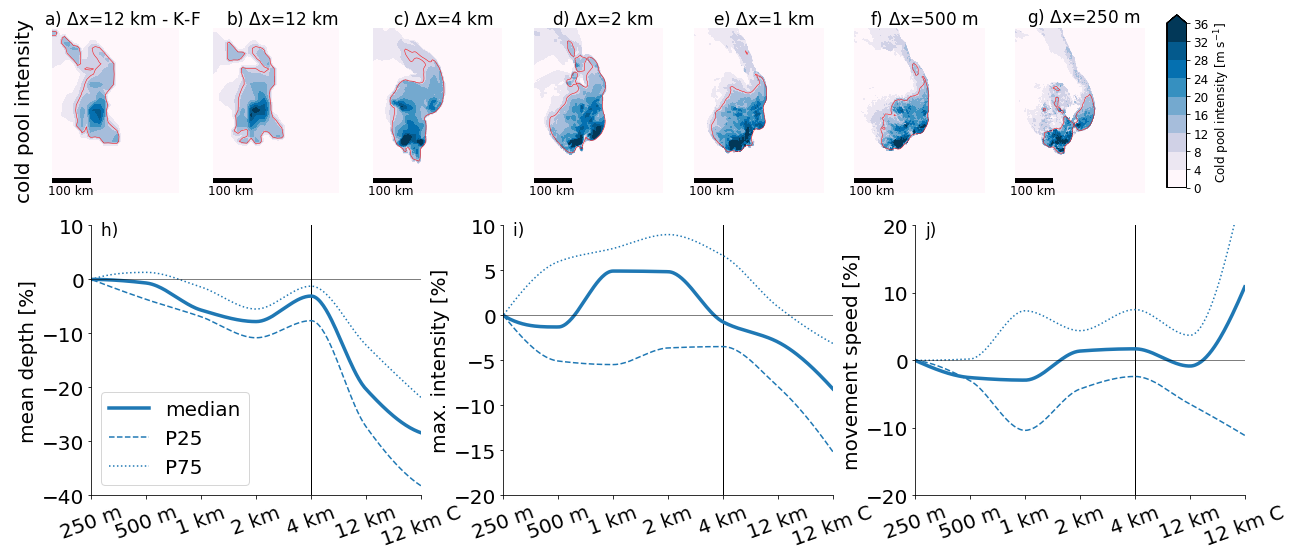

In [7]:
# set the font size
plt.rcParams.update({'font.size': 15})
rgsLableABC=list(string.ascii_lowercase)

fig = plt.figure(figsize=(18,7.5))
plt.rcParams.update({'font.size': 20})
gs1 = gridspec.GridSpec(1,len(rgrGridSpacing))
gs1.update(left=0.05, right=0.9,
           bottom=0.66, top=0.965,
           wspace=0.15, hspace=0.3)

nws_W_colors = ['#fff7fb','#ece7f2','#d0d1e6','#a6bddb','#74a9cf','#3690c0','#0570b0','#045a8d','#023858']
cStep=4.
levelsW = (np.array(range(len(nws_W_colors)+1))/float(len(nws_W_colors)))*cStep*len(nws_W_colors)

for dx in range(len(rgrGridSpacing)):
    rgrWact=ColdPoolIntAll[str(rgrGridSpacing[dx])+'_W']
    iSmooth=int(Smooth/rgrDX[dx])
    CPint_smooth=scipy.ndimage.uniform_filter(rgrWact,[iSmooth,iSmooth])
    
    rgrAxis=np.linspace(0,rgrWact.shape[0]*float(rgrDX[dx]),rgrWact.shape[0])/1000.
    ax = plt.subplot(gs1[0,dx])
    ax.axis('off')
    if dx == 0:
        ax.text(-0.2,0.5, 'cold pool intensity', ha='center', va='center', fontsize=20,transform = ax.transAxes, rotation=90) #, fontweight='bold')
    # plt W field
    cs = ax.contourf(rgrAxis, rgrAxis,rgrWact, levels=levelsW, colors=nws_W_colors, extend='max',zorder = 1)
    ax.contour(rgrAxis, rgrAxis, CPint_smooth, levels=[0,10,10000], colors=['r','r','r'], linewidths=0.5)
    cs.cmap.set_over('#023858')  
    sCBlabel='Cold pool intensity [m s$^{-1}$]' 
    TicksCB=levelsW

    # plot a line for scale reference
    ax.plot([260,360],[30,30],lw=5, c='k')
    ax.text(310,20,'100 km', ha='center', va='top', fontsize=12)

    if rgrGridSpacing[dx] == '250':
        ax.text(0.5,1, rgsLableABC[dx]+') $\Delta$x='+str(250)+' m', ha='center', va='bottom', 
                fontsize=17,transform = ax.transAxes) #, fontweight='bold')
    elif rgrGridSpacing[dx] == '500':
        ax.text(0.5,1, rgsLableABC[dx]+') $\Delta$x='+str(500)+' m', ha='center', va='bottom', 
                fontsize=17,transform = ax.transAxes) #, fontweight='bold')
    else:
        if rgrGridSpacing[dx] == '12000':
            # use of cumulus scheme
            ax.text(0.5,1,rgsLableABC[dx]+') $\Delta$x='+str(int(float(rgrDX[dx])/1000.))+' km - K-F', ha='center', va='bottom', 
                    fontsize=17,transform = ax.transAxes) #, fontweight='bold')
        else:
            ax.text(0.5,1,rgsLableABC[dx]+') $\Delta$x='+str(int(float(rgrDX[dx])/1000.))+' km', ha='center', va='bottom', 
                    fontsize=17,transform = ax.transAxes) #, fontweight='bold')
    plt.grid()
    ax.set_ylim([0,390])
    ax.set_xlim([260,650])
    ax.axis('off')        

    # add colorbar
    pos1 = ax.get_position()
    CbarAx = axes([0.91,0.67, 0.015, 0.32])
    cb = colorbar(cs, cax = CbarAx, orientation='vertical', extend='max', ticks=TicksCB) #, ticks=np.linspace(0,120,13))
    cb.set_label(label=sCBlabel,size=12)
    cb.ax.tick_params(labelsize=12)
    
    
    
    
# ------------------------------------
# Plot vertical mass flux differences

gs1 = gridspec.GridSpec(1,3)
gs1.update(left=0.08, right=0.97,
           bottom=0.1, top=0.60,
           wspace=0.25, hspace=0.25)

rgsStatsSel=['mean depth [km]', 'max. intensity [m s$^{-1}$]','movement speed [m s$^{-1}$]']

iXX=[0,1,2,0,1,2]
iYY=[0,0,0,1,1,1]
for st in range(len(rgsStatsSel)):
    ax = plt.subplot(gs1[iYY[st],iXX[st]])
    if rgsStatsSel[st] == 'mean depth [km]':
        DATA=CP_depth
        Yrange=[-40,10]
        Label='mean depth [%]'
    if rgsStatsSel[st] == 'max. intensity [m s$^{-1}$]':
        DATA=CP_intensity
        Yrange=[-20,10]
        Label='max. intensity [%]'
    if rgsStatsSel[st] == 'movement speed [m s$^{-1}$]':
        DATA=CP_speed
        Yrange=[-20,20]
        Label='movement speed [%]'

    Xaxis=np.round(np.arange(0,len(rgrGridSpacing)+0.025,0.025),3)
    RealPoints = [np.where(Xaxis == ii)[0][0] for ii in range(len(rgrDX))]

    col='#1f78b4'
    DATA_pe=np.nanmean(DATA[12*3:,:10,:], axis=(0))

    Data_Diff=((DATA_pe[:,:]-DATA_pe[:,-1][:,None])/DATA_pe[:,-1][:,None])*100.
    # median
    DataInt=np.copy(Xaxis); DataInt[:]=np.nan; DataInt[RealPoints[:]]=np.nanmedian(Data_Diff, axis=0)
    s = pd.Series(DataInt)
    plt.plot(Xaxis[::-1], s.interpolate(method='pchip'), c=col, lw=3.5, alpha=1, label='median')

    # plot P25-P75
    P25=np.copy(Xaxis); P25[:]=np.nan; P25[RealPoints[:]]=np.nanpercentile(Data_Diff, 25, axis=0)
    s25 = pd.Series(P25)
    ax.plot(Xaxis[::-1],s25.interpolate(method='pchip'), c=col, ls='--', label='P25')
    P75=np.copy(Xaxis); P75[:]=np.nan; P75[RealPoints[:]]=np.nanpercentile(Data_Diff, 75, axis=0)
    s75 = pd.Series(P75)
    ax.plot(Xaxis[::-1],s75.interpolate(method='pchip'), c=col, ls=':', label='P75')

    labels = np.array([ '12 km C',  '12 km',  '4 km', '2 km','1 km','500 m', '250 m'])
    
    xx = (np.array([0.5,1.5, 2.5, 3.5,4.5,5.5,6.5])+0.5)[::-1]
    labels = np.array([ '12 km C',  '12 km',  '4 km', '2 km','1 km','500 m', '250 m'])
    plt.xticks(xx, labels, rotation=20)
    ax.get_xaxis().get_major_formatter().labelOnlyBase = False

    ax.set_ylabel(Label)
    if iYY[st] == 1:
        ax.set_xlabel('horizontal grid spacing [km]')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(1, 7)
    plt.axhline(y=0, c='k', lw=0.5)
    plt.ylim(Yrange[0],Yrange[1])
    ax.axvline(x=5, ls='-', c='k', zorder=-1, alpha=1, lw=1)

    if (st == 0):
        plt.legend(loc="lower left",
                   ncol=1, prop={'size':20})
        
    ax.text(0.03,0.95, rgsLableABC[st+7]+') ', ha='left',va='bottom', \
            transform = ax.transAxes, fontname="Times New Roman Bold", fontsize=17)

# Plot the figure
sPlotFile=sPlotDir
sPlotName= 'Fig05_ColdPoolProperties.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print '        Plot map to: '+sPlotFile+sPlotName
fig.savefig(sPlotFile+sPlotName)